# Yulu Electric Cycle Demand Analysis

## Business Context & Problem Statement

Yulu is India’s leading micro-mobility service provider offering shared electric cycles and scooters for first- and last-mile connectivity. Recently, Yulu has experienced a dip in revenues and wants to understand which factors drive the demand for its shared electric cycles.

**Business Problem**

The management wants to answer the following questions:

1. Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
2. How well do these variables explain the variation in electric cycle demand (rental counts)?

The key dependent variable is:

- **count**: total rental bikes (casual + registered) used on a given datetime.

Key independent variables include:

- **datetime**: date and time of observation  
- **season**: 1 = spring, 2 = summer, 3 = fall, 4 = winter  
- **holiday**: 1 if the day is a holiday, else 0  
- **workingday**: 1 if the day is a working day (not a weekend/holiday), else 0  
- **weather**: categorical weather situation (1–4)  
- **temp**: temperature (°C)  
- **atemp**: "feels like" temperature (°C)  
- **humidity**: relative humidity  
- **windspeed**: wind speed  
- **casual**: # casual users  
- **registered**: # registered users  

## Objectives of This Analysis

1. Perform **exploratory data analysis (EDA)** to understand distributions, outliers, and relationships.
2. Perform **hypothesis testing** to check:
   - Whether **working days** have an effect on the number of cycles rented (2-sample t-test).
   - Whether the number of cycles rented differs across **seasons** (ANOVA).
   - Whether the number of cycles rented differs across **weather conditions** (ANOVA).
   - Whether **weather** is dependent on **season** (Chi-square test).

3. Summarize **key insights** and provide **data-driven recommendations** for Yulu.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("bike_sharing.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data Understanding & Cleaning

In this section, we will:
- Inspect the structure and data types.
- Check for missing values.
- Convert variables to appropriate data types (e.g. categorical).
- Extract useful time-based features from `datetime`.

In [3]:
df.shape

(10886, 12)

In [4]:
df.columns.to_list()

['datetime',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'casual',
 'registered',
 'count']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [7]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [8]:
# Convert datetime and extract date-related features
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

In [9]:
cat_cols = ['season', 'holiday', 'workingday', 'weather']
for cols in cat_cols:
    df[cols] = df[cols].astype("category")
df.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
date                  object
year                   int32
month                  int32
day                    int32
dtype: object

### Observations on Data Structure

- The dataset has shape `10886 x 12`.
- Key categorical variables: `season`, `holiday`, `workingday`, `weather`.
- Key continuous variables: `temp`, `atemp`, `humidity`, `windspeed`, `casual`, `registered`, `count`.
- `datetime` has been converted to a proper datetime type and decomposed into `year`, `month`, `day`.

There are no missing values.

## Univariate Analysis

We explore the distribution of individual variables to understand:

- Central tendency and spread.
- Presence of outliers.
- Skewness / normality characteristics.

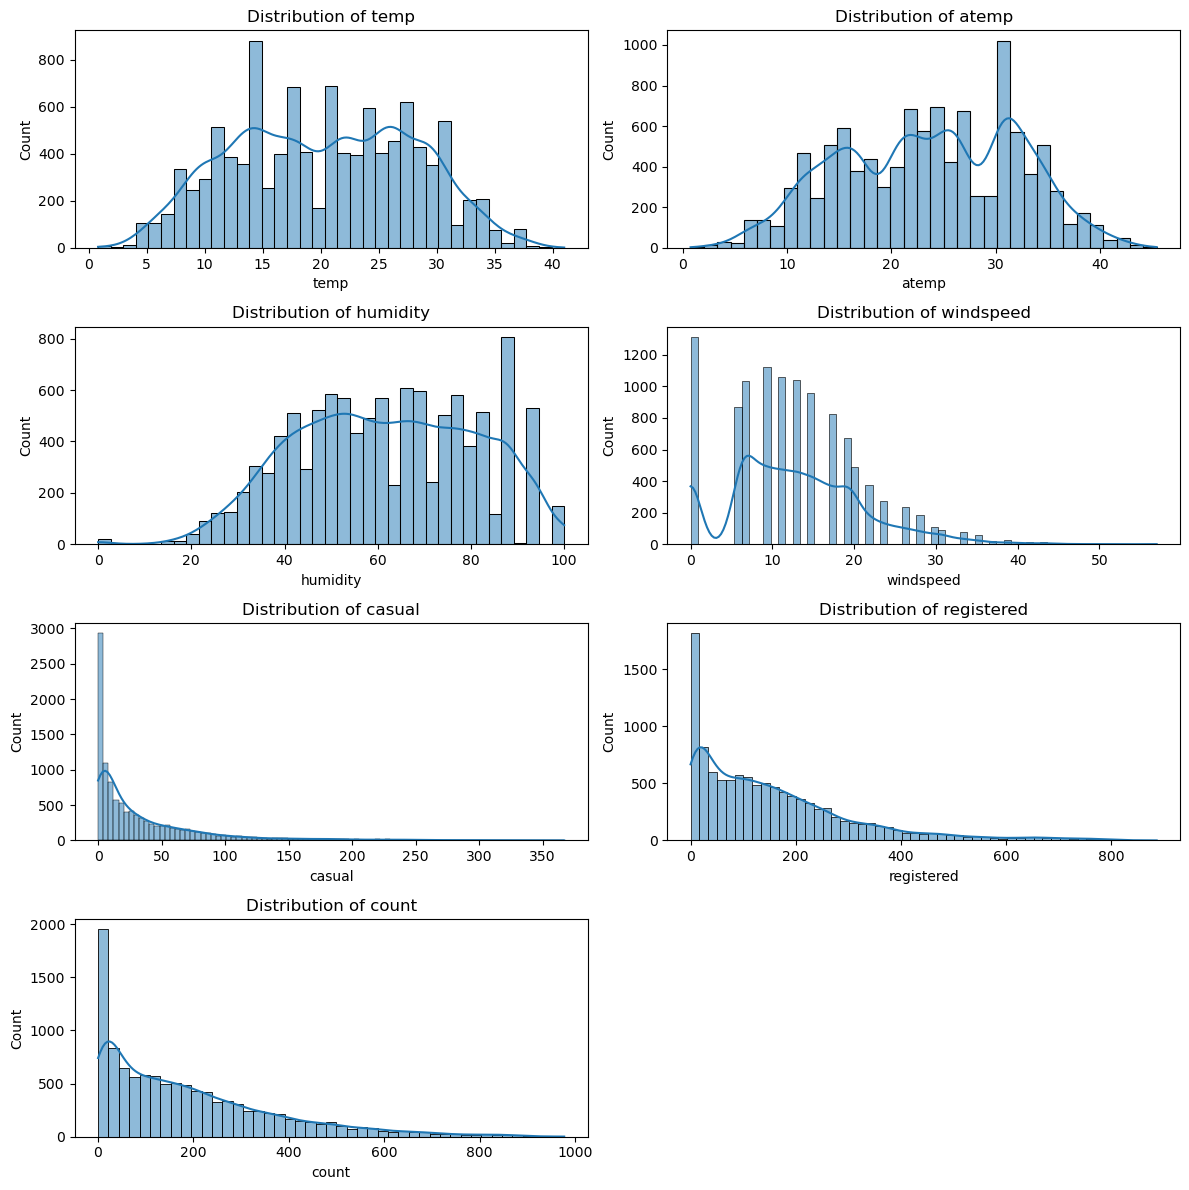

In [10]:
num_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
plt.figure(figsize=(12, 12))
for i, cols in enumerate(num_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[cols], kde=True)
    plt.title(f"Distribution of {cols}")
plt.tight_layout()
plt.show()

### Comments on Continuous Variables

- **temp / atemp**: Typically concentrated around 10–32 °C.
- **humidity**: Higher concentration at upper ranges.
- **windspeed**: Right-skewed with many low-wind observations.
- **casual vs registered**: Registered users dominate total counts.
- **count**: Skewed towards right.

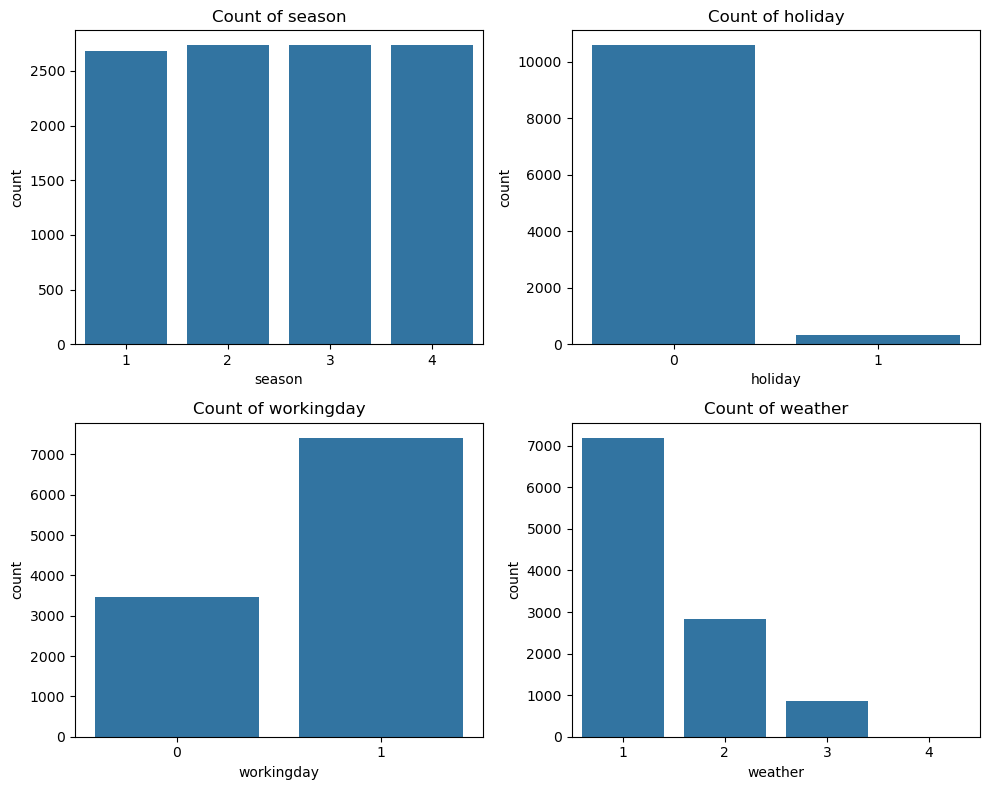

In [11]:
plt.figure(figsize=(10, 8))
for i, cols in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=df[cols])
    plt.title(f"Count of {cols}")
plt.tight_layout()
plt.show()

### Comments on Categorical Variables

- **season**: All seasons have similar observations (data collection is uniform).
- **holiday**: Non-holiday days dominate.
- **workingday**: More working days than non-working days.
- **weather**: Most days fall into weather category 1 (clear to partly cloudy), with fewer extreme weather day counts.

These distributions will influence how much evidence we have in each group for hypothesis testing.

## Bivariate Analysis

We now explore how the target variable `count` relates to key predictors:

- `workingday` vs `count`
- `season` vs `count`
- `weather` vs `count`
- `temp` vs `count`
- `humidity` vs `count`
- Correlations among continuous variables

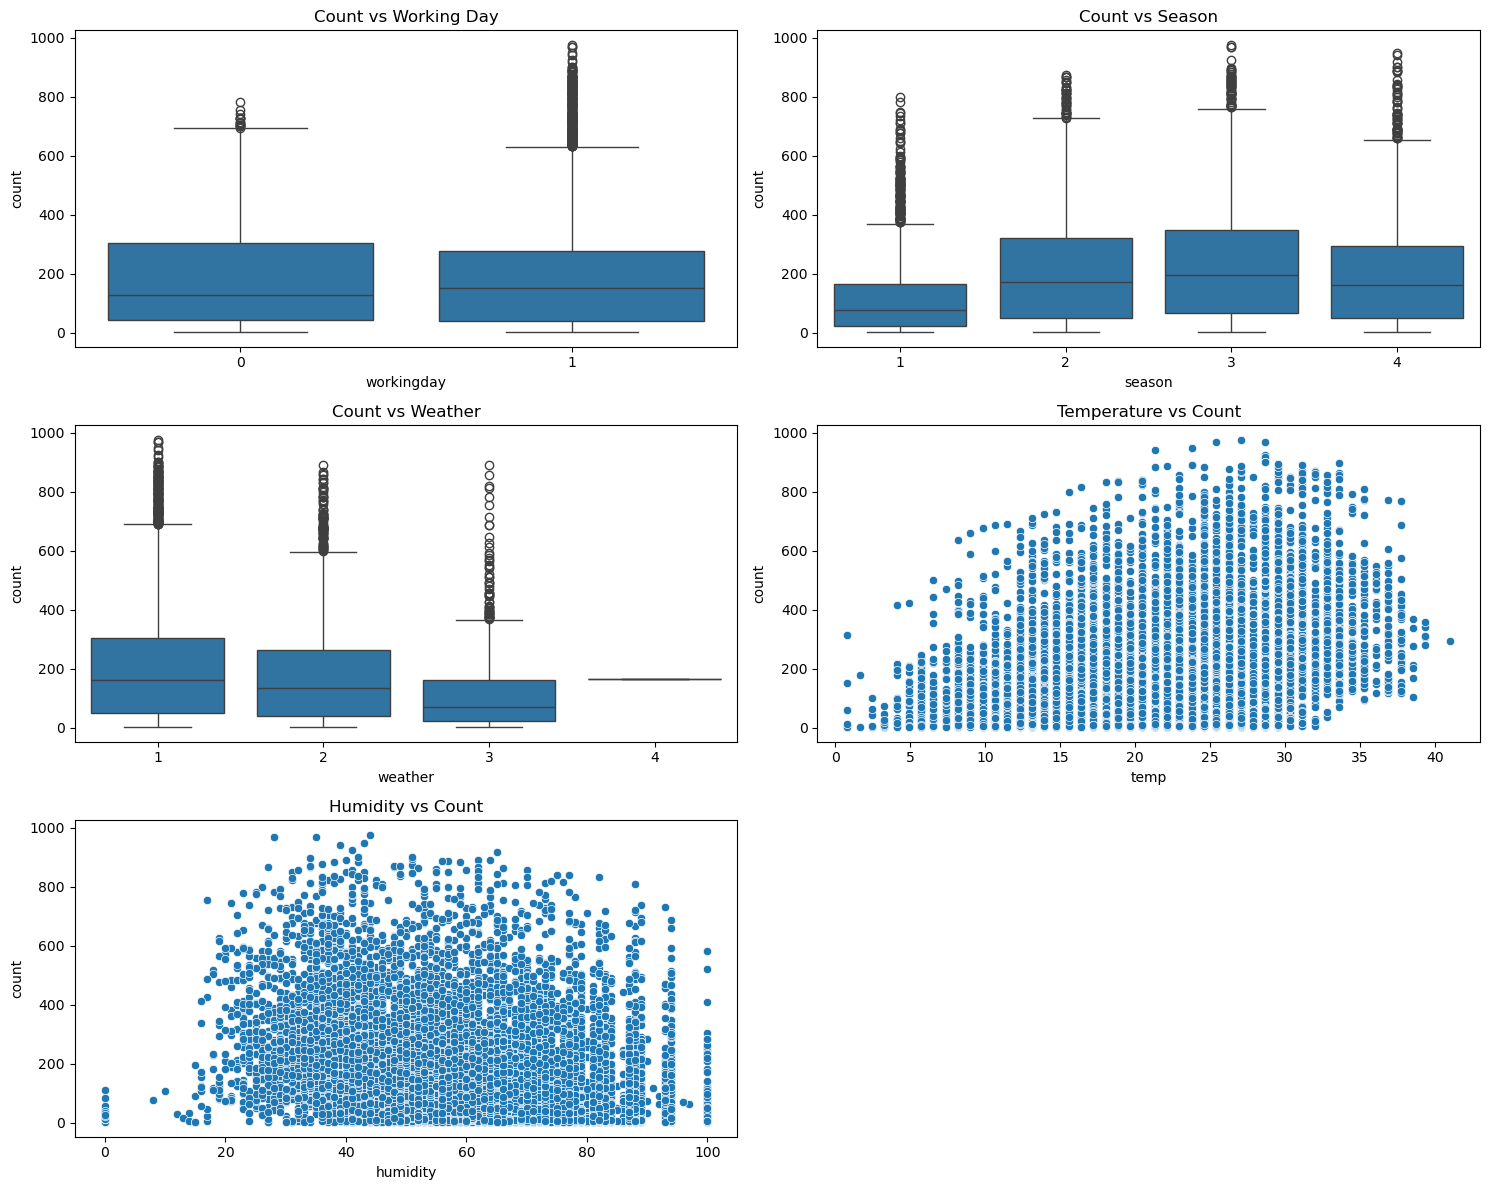

In [12]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
sns.boxplot(x='workingday', y='count', data=df)
plt.title("Count vs Working Day")

plt.subplot(3, 2, 2)
sns.boxplot(x='season', y='count', data=df)
plt.title("Count vs Season")

plt.subplot(3, 2, 3)
sns.boxplot(x='weather', y='count', data=df)
plt.title("Count vs Weather")

plt.subplot(3, 2, 4)
sns.scatterplot(x='temp', y='count', data=df)
plt.title("Temperature vs Count")

plt.subplot(3, 2, 5)
sns.scatterplot(x='humidity', y='count', data=df)
plt.title("Humidity vs Count")

plt.tight_layout()
plt.show()

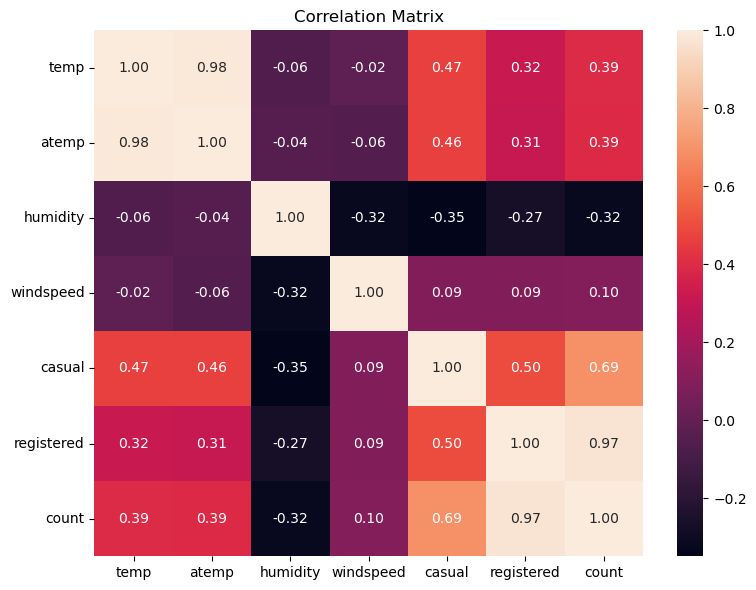

In [13]:
plt.figure(figsize=(8, 6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Observations
**Count vs Workingday**
- Median rentals appear slightly higher on working days.

**Count vs Season**
- **Season 3** appears to have the highest median demand, immediately followed by **Season 2**.

**Count vs Weather**
- Mean/median rentals drop in bad weather, which is expected.
- Extreme weather categories have fewer observations.

**Correlation Among Continuous Variables**
- `temp` and `atemp` are highly correlated.
- `count` is strongly correlated with `registered` and moderately with `casual`.
- Weather-related variables - `temp` and `atemp` slight positive correlation with `count`; `humidity` slight negative correlation with `count`.

These observations guide which variables are promising predictors for demand.

## Hypothesis Testing

### Does Working Day Affect Rentals?

**Objective:** Test whether the mean number of cycles rented on working days is different from non-working days.

- **Null Hypothesis ($H_{0}$):**  
  The mean rental count on working days equals the mean rental count on non-working days.  
  μ_workingday = μ_nonworking

- **Alternative Hypothesis ($H_{a}$):**  
  The mean rental count on working days is different from that on non-working days.  
  μ_workingday $\neq$ μ_nonworking  

- **Test Type:** Independent 2-sample t-test (workingday = 0 vs workingday = 1).
- **Significance Level ($\alpha$):** 0.05

In [14]:
wd = df[df['workingday']==1]['count']
nwd = df[df['workingday']==0]['count']

t_stat, p_value = ttest_ind(wd, nwd, equal_var=False)
t_stat, p_value

(1.2362580418223226, 0.21640312280695098)

#### t-Test Results & Conclusion

- **t-statistic:** (1.236)
- **p-value:** (0.216)

At $\alpha$ = 0.05:
- **p-value ≥ 0.05**: Fail to reject $H_{0}$.  
  > There is no statistically significant evidence that working days and non-working days differ in mean rental count.

### Do Seasons Affect Rentals?

**Objective:** Test if the mean rental count is the same across all seasons.

- **Null Hypothesis ($H_{0}$):**  
  μ_season1 = μ_season2 = μ_season3 = μ_season4

- **Alternative Hypothesis ($H_{a}$):**  
  At least one season has a different mean rental count.

- **Test Type:** One-way ANOVA  
- **Significance Level ($\alpha$):** 0.05

In [15]:
# Create groups for each season
seasons = df['season'].unique()
season_groups = [df[df['season'] == s]['count'] for s in seasons]

for s, g in zip(seasons, season_groups):
    print(f"Season {s} | n = {len(g)} | mean = {g.mean():.2f}")

Season 1 | n = 2686 | mean = 116.34
Season 2 | n = 2733 | mean = 215.25
Season 3 | n = 2733 | mean = 234.42
Season 4 | n = 2734 | mean = 198.99


In [16]:
from scipy.stats import shapiro

for s, g in zip(seasons, season_groups):
    stat, p = shapiro(g)
    print(f"Season {s}: Shapiro p-value = {p:.4f}")

Season 1: Shapiro p-value = 0.0000
Season 2: Shapiro p-value = 0.0000
Season 3: Shapiro p-value = 0.0000
Season 4: Shapiro p-value = 0.0000


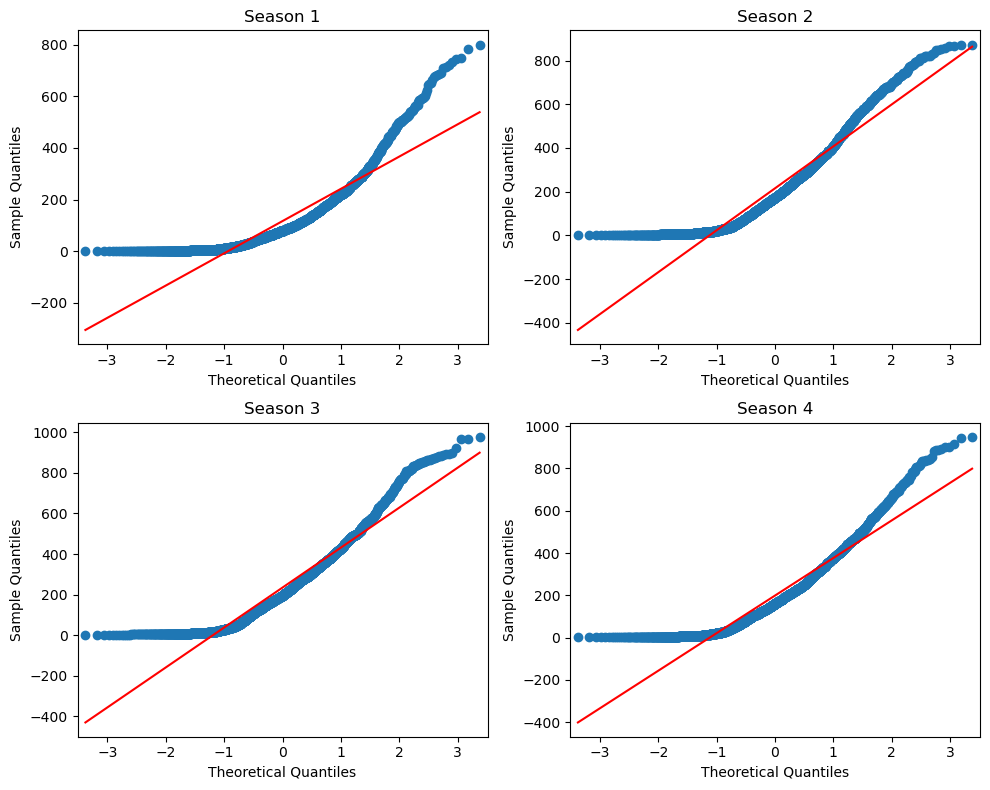

In [17]:
import statsmodels.api as sm

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, s, g in zip(axes, seasons, season_groups):
    sm.qqplot(g, line='s', ax=ax)
    ax.set_title(f'Season {s}')

plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import levene

stat, p = levene(*season_groups)
print(f"Levene Test p-value = {p:.4f}")

Levene Test p-value = 0.0000


In [19]:
f_stat, p_val = f_oneway(*season_groups)
print(f"F-statistic = {f_stat:.4f} | p-value = {p_val:.4e}")

F-statistic = 236.9467 | p-value = 6.1648e-149


#### ANOVA Result — Season vs Count
- F-statistic: {236.9467}
- p-value: {6.1648e-149}

**p-value < 0.05** → Reject $H_{0}$:  
- There is a statistically significant difference in mean rental counts across seasons.

### Do Weather Conditions Affect Rentals?

**Objective:** Test if mean rentals differ across weather situations (1 to 4).

- **Null Hypothesis ($H_{0}$):**  
  μ_weather1 = μ_weather2 = μ_weather3 = μ_weather4

- **Alternative Hypothesis ($H_{a}$):**  
  At least one weather category has a different mean rental count.

- **Test Type:** One-way ANOVA  
- **Significance Level ($\alpha$):** 0.05

In [20]:
df['weather'].value_counts()

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64

In [21]:
weathers = df['weather'].unique()
groups_weather = [df[df['weather'] == w]['count'] for w in weathers]

for w, g in zip(weathers, groups_weather):
    print(f"Weather {w} | n = {len(g)} | mean = {g.mean():.2f}")

Weather 1 | n = 7192 | mean = 205.24
Weather 2 | n = 2834 | mean = 178.96
Weather 3 | n = 859 | mean = 118.85
Weather 4 | n = 1 | mean = 164.00


In [22]:
for w, g in zip(weathers, groups_weather):
    stat, p = shapiro(g)
    print(f"Weather {w}: Shapiro p-value = {p:.4f}")

Weather 1: Shapiro p-value = 0.0000
Weather 2: Shapiro p-value = 0.0000
Weather 3: Shapiro p-value = 0.0000
Weather 4: Shapiro p-value = nan


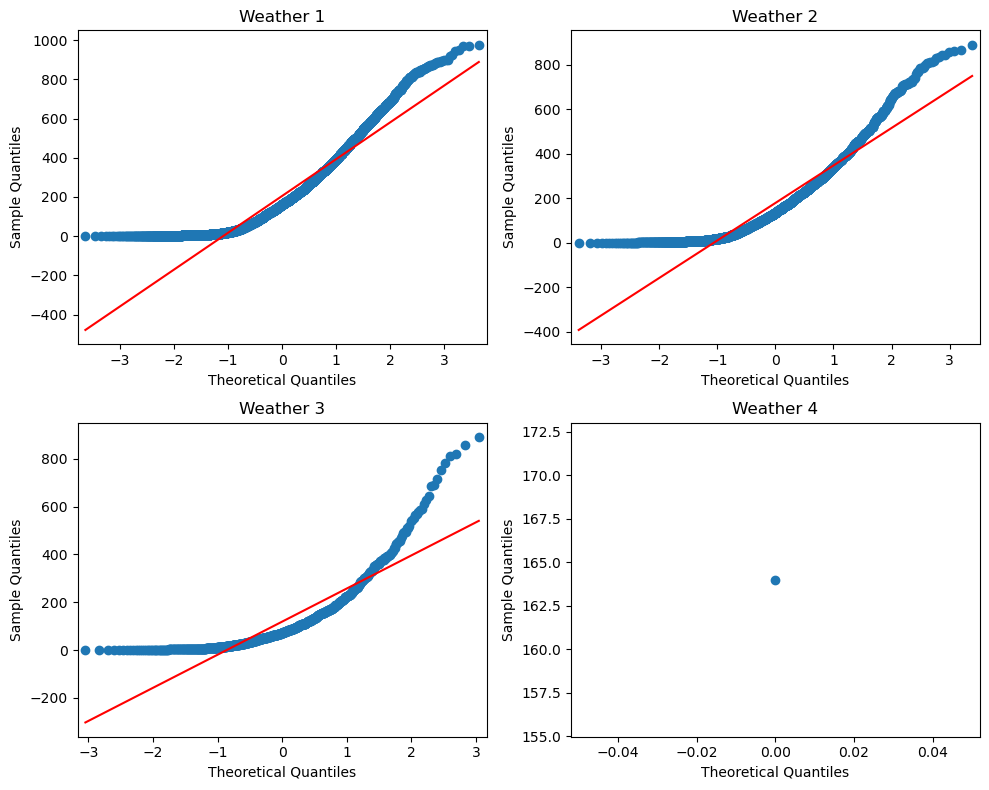

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, w, g in zip(axes, weathers, groups_weather):
    sm.qqplot(g, line='s', ax=ax)
    ax.set_title(f'Weather {w}')

plt.tight_layout()
plt.show()

In [24]:
stat, p = levene(*groups_weather)
print(f"Levene Test p-value = {p:.4f}")

Levene Test p-value = 0.0000


In [25]:
f_stat, p_val = f_oneway(*groups_weather)
print(f"F-statistic = {f_stat:.4f} | p-value = {p_val:.4e}")

F-statistic = 65.5302 | p-value = 5.4821e-42


#### ANOVA Result — Weather vs Count
- F-statistic: {65.5302}
- p-value: {5.4821e-42}

**p-value < 0.05** → Reject $H_{0}$:  
- Weather significantly affects the number of rentals (e.g., demand drops during bad weather).

### Weather vs Season

**Objective:** Check if the distribution of weather categories is independent of the season.

- **Null Hypothesis ($H_{0}$):**  
  Season and weather are independent.

- **Alternative Hypothesis ($H_{a}$):**  
  Season and weather are not independent (weather distribution depends on season).

- **Test Type:** Chi-square test of independence  
- **Significance Level ($\alpha$):** 0.05

In [26]:
# Contingency table
contingency = pd.crosstab(df['season'], df['weather'])
contingency

weather,1,2,3,4
season,,,,
1,1759,715,211,1
2,1801,708,224,0
3,1930,604,199,0
4,1702,807,225,0


In [27]:
chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
chi2_stat, p_value, dof

(49.158655596893624, 1.5499250736864915e-07, 9)

#### Chi-square Results & Conclusion

- **Chi-square statistic:** {49.1586}
- **Degrees of freedom:** {9}
- **p-value:** {1.549e-07}

At $\alpha$ = 0.05:

- If **p-value < 0.05**: Reject $H_{0}$.  
  > Weather is dependent on season (e.g., some weather types occur more often in specific seasons).

## Key Insights & Business Recommendations

### Summary of Statistical Findings

- **Working Day Effect (t-test):**
  - There is no statistically significant evidence that working days and non-working days differ in mean rental count.
  - Business implication: Focus fleet availability and maintenance planning around days with higher demand.

- **Seasonal Effect (ANOVA):**
  - There is a statistically significant difference in mean rental counts across seasons.
  - With **Season 2 and 3** being more high demand seasons.
  - Business implication: Plan seasonal campaigns, pricing, and capacity (more bikes in high-demand seasons).

- **Weather Effect (ANOVA):**
  - Weather significantly affects the number of rentals(e.g., demand drops during bad weather).
  - Business implication: On days with adverse weather, expect lower demand, plan dynamic pricing or promotions.

- **Weather vs Season (Chi-square):**
  - Weather is dependent on season (e.g., some weather types occur more often in specific seasons).
  - Business implication: Combine seasonal patterns with weather forecasts to anticipate demand.

### Overall Recommendations for Yulu

- **Demand Forecasting:** Use season and weather as key predictors in a forecasting model for rental counts.
- **Operational Planning:** Allocate more vehicles and charging support in high-demand periods (e.g., working days in peak seasons with good weather).
- **Marketing Strategy:** Run promotions during low-demand conditions (e.g., non-working days or adverse weather) to smooth demand.
- **Future Work:**
  - Build a regression or time-series model using these variables to predict daily/hourly demand.
  - Incorporate additional features (events, location-level data) for finer-grained insights.

### Project: Yulu Electric Cycle Demand Analysis

Analyzed shared electric cycle rental data to understand how working days, seasons, and weather conditions influence demand.

- Performed comprehensive EDA on rental counts, weather, and calendar features using Python (pandas, seaborn, matplotlib).
- Applied statistical hypothesis tests:
  - 2-sample t-test to quantify the impact of working days on demand.
  - One-way ANOVA to compare mean rentals across different seasons and weather types.
  - Chi-square test of independence to examine the relationship between weather and season.
- Derived actionable insights to help Yulu optimize fleet allocation, pricing, and operational planning around high- and low-demand periods.